# **Día 2:** Lines

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the name that is used to seach for the data
place_name = "Easter Island, Chile"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)

fig_kwargs = dict(figsize=(12, 12), bgcolor='white', node_color='k', node_size=2.5, node_alpha=None, node_edgecolor='none', 
                  node_zorder=1, edge_color='k', edge_linewidth=0.75, edge_alpha=None, show=True, close=False, save=False, 
                  filepath=None, dpi=300, bbox=None)

fig, ax = ox.plot_graph(graph, **fig_kwargs)

# Save nodes and edges from the location
ox.io.save_graph_geopackage(graph, filepath="data/EasterIsland/EasterIsland.gpkg")

# **Day 07 and 08:** Green and Blue

In [ ]:
import pandas as pd
import geopandas as gpd
from IPython.display import display

df = pd.read_csv("data/chile/sdm-102021.csv")
display(df.head())
gdf = gpd.read_file("data/chile/COMUNA/COMUNAS_2020.shp").astype({"CUT_REG": "int64", "CUT_PROV": "int64","CUT_COM": "int64",})
display(gdf.head())

In [ ]:
df.columns 

In [ ]:
rename_columns  = {" N° Hombre": "N_Hombre", " Mto.Hombre": "Monto_Hombre", "Nº Mujer": "N_Mujer", " Mto.Mujer": "Monto_Mujer", " Nº": "N_Total", " Monto m$": "Monto_Total"} 
drop_columns    = ["Región", "Cód Comuna", "Glosa Comuna", "cod_reg", "SUPERFICIE"]
reindex_columns = ["CUT_REG", "CUT_PROV", "CUT_COM", "REGION", "PROVINCIA", "COMUNA", 
"N_Hombre", "Monto_Hombre", "N_Mujer", "Monto_Mujer", "N_Total", "Monto_Total", "geometry"]

join_df = gpd.GeoDataFrame(df.merge(gdf, how="inner", left_on="Cód Comuna", right_on ="CUT_COM")\
    .rename(columns = rename_columns)\
        .drop(columns = drop_columns)\
            .reindex(columns = reindex_columns)).set_crs("EPSG:4326", allow_override=True)
join_df.head()

In [ ]:
join_df.plot()

In [ ]:
def save_geodataframe(gdf, filepath):
    for geotype in ['Point', 'LineString', 'Polygon', 'MultiPoint', 'MultiLineString', 'MultiPolygon']:
        if (gdf.geometry.geom_type == geotype).any():
            gdf.loc[gdf.geometry.geom_type == geotype].to_file(filepath, driver="GPKG", layer=geotype)

save_geodataframe(join_df, "data/chile/sdm-102021.gpkg")

In [ ]:
group_df = df.groupby("Región").sum()
group_df['montoxpersona'] = group_df[' Monto m$']/group_df[' Nº']
group_df.to_csv("data\chile\group_sdm-102021.csv")

# **Day 10:** Raster

In [3]:
import numpy as np
import xarray as xr
import cdsapi
import os
import rioxarray
import cartopy.crs as ccrs

In [ ]:
def request_info_from_copernicus(dataset_short_name, kwargs_request, path_folder, name_file):
    #start client
    c = cdsapi.Client()
    #check if folder is created
    if os.path.isdir(path_folder) == False:
        os.mkdir(path_folder)
    else:
        pass
    #start request
    c.retrieve(
        dataset_short_name, 
        kwargs_request, 
        path_folder+name_file
        )
    return

In [ ]:
dataset_short_name  = 'reanalysis-era5-single-levels'
# month               = ['0'+str(n) if n<9 else str(n) for n in np.linspace(1, 12, 12, dtype=int)] 
# year                = [str(n) for n in np.linspace(2016, 2020, 5, dtype=int)]
path_folder         = 'data/WORLD/'

for y in ['2021']:#year:
    for m in ["08"]:#['0'+str(n) if n<9 else str(n) for n in np.linspace(1, 12, 12, dtype=int)]:
        print(f"started year: {y}, month: {m}")
        name_file       = 'waves'+y+m+'.grib'
        kwargs_request  = dict(
            format = 'grib', 
            area = [90, -180, -90, 180,], #North, West, South, East
            variable = ['mean_wave_direction', 'peak_wave_period', 'significant_height_of_combined_wind_waves_and_swell',],
            time   = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00',],
            day    = ['0'+str(n) if n<9 else str(n) for n in np.linspace(1, 31, 31, dtype=int)],
            month  = [m], 
            year=[y],
            product_type = 'reanalysis',
        )
        request_info_from_copernicus(dataset_short_name, kwargs_request, path_folder, name_file)
        print(f"finished year: {y}, month: {m}")

In [4]:
ds = xr.open_dataset('data/WORLD/waves202108.grib', drop_variables=["number", "step", "meanSea", "valid_time"], decode_coords="all").rename({"pp1d": "Tp"})
ds['Te'] = ds['Tp']*0.9
ds['Power'] = 0.5*ds.Te*(ds.swh**2)
ds = ds.rio.write_crs("epsg:4326").drop_vars(["spatial_ref"])

In [ ]:
def plotting_data(ds, variable, t_i, vmin, vmax, cmap, nombre_variable, format_date, cbar_label):
    fig = plt.figure(figsize=(21,9))
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    obj = ds.isel(time=t_i)[variable].plot.pcolormesh(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cbar_kwargs={"label": cbar_label, 'extend':'max'})
    ax.coastlines()
    ax.gridlines(linestyle=":", draw_labels=True)
    ax.set_extent([-180, 180, -90, 90])
    ax.set_title(f"{pd.to_datetime(ds.time[t_i].values, format_date).strftime(format_date)}", fontsize=14, fontweight='bold')
    obj.colorbar.set_label("Altura significativa (m)", fontsize=12, fontweight='bold')
    fig.savefig("data/WORLD/frames/"+variable+"_"+str(t_i)+".png", dpi=300, bbox_inches='tight', edgecolor='black', facecolor='white')
    plt.close(fig)
    return fig

for t_i in range(0, len(ds.time)):
    # print(f"started time: {t_i}")
    fig = plotting_data(ds, "swh", t_i, vmin=0, vmax=8, cmap='jet', nombre_variable="Altura significativa (m)", format_date="%Y-%m-%d %H:%M:%S", cbar_label="Altura significativa (m)")
    print(f"finished time: {t_i}")

In [5]:
import os
variable = "swh"
for t_i in range(0, len(ds.time)):
    if t_i < 10:
        os.rename("data/WORLD/frames/"+variable+"_"+str(t_i)+".png", "data/WORLD/frames/"+variable+"_00"+str(t_i)+".png")
    elif t_i < 100:
        os.rename("data/WORLD/frames/"+variable+"_"+str(t_i)+".png", "data/WORLD/frames/"+variable+"_0"+str(t_i)+".png")
    else:
        pass

# **Day 12:** Population

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [39]:
gdf_comuna  = gpd.read_file("data\chile\censo2017\conce\Microdatos_Manzana_conce.shp")

In [40]:
print("Columnas shapefile por comunas:", gdf_comuna.columns)

Columnas shapefile por comunas: Index(['OBJECTID', 'CUT', 'REGION', 'PROVINCIA', 'COMUNA', 'MANZENT_I',
       'DISTRITO', 'COD_DISTRI', 'COD_LOCALI', 'COD_ENTIDA', 'CATEGORIA',
       'COD_CATEGO', 'PERSONAS', 'HOMBRES', 'MUJERES', 'DE_0_A_5_A',
       'DE_6_A_14_', 'DE_15_A_64', 'DE_65_MAS_', 'INMIGRANTE', 'PUEBLOS_OR',
       'VIVIENDAS_', 'VIVIENDA_1', 'VIV_OCUPAD', 'TOTAL_VIVI', 'TOT_HOGARE',
       'CASA', 'DEPTO', 'VIV_INDIGE', 'CONVENTILL', 'MEDIAGUA', 'MOVIL',
       'OTRA_VIV_P', 'VIV_HORMIG', 'VIV_ALBANI', 'VIV_TABIQU', 'VIV_TABI_1',
       'VIV_ADOBE', 'VIV_PARED_', 'VIV_TEJAS_', 'VIV_LOSA_H', 'VIV_PLANCH',
       'VIV_FONOLI', 'VIV_PAJA', 'VIV_TECHO_', 'VIV_SIN_TE', 'VIV_PARQUE',
       'VIV_RADIER', 'VIV_BALDOS', 'VIV_CAPA_C', 'VIV_PISO_T', 'IND_MAT_AC',
       'IND_MAT_RE', 'IND_MAT_IR', 'VIV_AGUA_R', 'VIV_AGUA_P', 'VIV_AGUA_C',
       'VIV_AGUA_1', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')


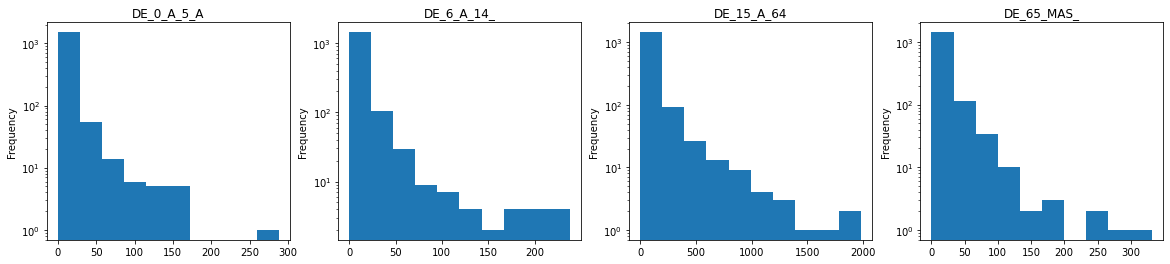

In [43]:
fig, axes = plt.subplots(ncols = 4, figsize=(20,4))

for ax, col_name in zip(axes, ['DE_0_A_5_A','DE_6_A_14_', 'DE_15_A_64', 'DE_65_MAS_']):
    gdf_comuna[col_name] = gdf_comuna[col_name].replace({'Indeterminado':0}).astype("int64")
    gdf_comuna[col_name].plot(kind='hist', ax=ax, logy=True)
    ax.set_title(col_name)

In [49]:
gdf_comuna[['DE_0_A_5_A','DE_6_A_14_', 'DE_15_A_64', 'DE_65_MAS_']].describe()

,DE_0_A_5_A,DE_6_A_14_,DE_15_A_64,DE_65_MAS_
count,1600.000000,1600.000000,1600.000000,1600.000000
mean,7.553125,11.173750,96.109375,16.169375
std,17.585874,23.539565,160.067543,23.313792
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,31.000000,4.000000
50%,4.000000,6.000000,53.500000,11.000000
75%,8.000000,12.000000,91.000000,20.000000
max,288.000000,238.000000,1980.000000,332.000000


In [48]:
def save_geodataframe(gdf, filepath):
    for geotype in ['Point', 'LineString', 'Polygon', 'MultiPoint', 'MultiLineString', 'MultiPolygon']:
        if (gdf.geometry.geom_type == geotype).any():
            gdf.loc[gdf.geometry.geom_type == geotype].to_file(filepath, driver="GPKG", layer=geotype)

save_geodataframe(gdf_comuna, "data\chile\censo2017\conce\Microdatos_Manzana_conce.gpkg")

# Extras

In [ ]:
from IPython.display import display

tags = {"landuse":True}
landuse = ox.geometries_from_place(place_name, tags=tags)
display(landuse.head())
display(landuse.geometry.geom_type.unique())

In [ ]:
import numpy as np
import xarray as xr
import cdsapi
import os
import rioxarray
ds = xr.open_dataset("data/Portugal/20211109_011920_GFS_P25_.grb2", drop_variables=["time", "heightAboveGround"])
# ds.coords['longitude'] = (ds.coords['longitude'] + 180) % 360 - 180
ds["wind"] = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
ds = ds.swap_dims({'step': 'valid_time'}).drop_vars(["step"]).rename({'valid_time': 'time'})


new_longitude = np.linspace(ds.longitude.min(), ds.longitude.max(), len(ds.longitude)*10)
new_latitude = np.linspace(ds.latitude.min(), ds.latitude.max(), len(ds.latitude)*10)

# ds_interp = ds.interp(longitude=new_longitude, latitude=new_latitude, method='linear')\
ds_interp = ds.sel(time=slice('2021-11-09T00:00:00', '2021-11-09T21:00:00'))\
        .mean(dim="time")
ds_interp = ds_interp.sortby(["latitude", "longitude"])
ds_interp.rio.write_crs("epsg:4326", inplace=True)
ds_interp.to_netcdf("data/Portugal/20211109_011920_GFS_P25_MEAN.nc")